In [1]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 81.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.7 MB/s eta 0:00:00


### 사전 학습된 BERT 불러오기

In [2]:
import pandas as pd
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from transformers import BertTokenizer, BertModel, BertConfig
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tqdm import tqdm

In [3]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [4]:
# 데이터 불러오기
df = pd.read_csv('complete.csv')
df['text'] = df['title'] + ' ' + df['content']
# NaN 값을 포함하는 행 삭제
df.dropna(subset=['text'], inplace=True)

In [5]:
def remap_label(label):
    if label == 1 or label == 2:
        return 1
    elif label == 3:
        return 2
    elif label == 4 or label == 5:
        return 3
    else:
        return label  # 0의 경우 그대로 반환

df['label2'] = df['label2'].apply(remap_label)


In [6]:
# 원본 데이터를 학습 데이터와 테스트 데이터로 나눔
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [7]:
# KoBERT 토크나이저 로드
tokenizer = BertTokenizer.from_pretrained('monologg/kobert')

In [8]:
def encode_data(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []

    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        # 직접 패딩 수행
        padding_length = max_len - len(encoded_dict['input_ids'][0])
        all_tokens.append(torch.cat([encoded_dict['input_ids'], torch.zeros((1, padding_length), dtype=torch.long)], dim=1))
        all_masks.append(torch.cat([encoded_dict['attention_mask'], torch.zeros((1, padding_length), dtype=torch.long)], dim=1))

    all_tokens = torch.cat(all_tokens, dim=0)
    all_masks = torch.cat(all_masks, dim=0)

    return all_tokens, all_masks


In [9]:
# 학습 데이터 인코딩
train_input_ids, train_attention_masks = encode_data(train_df['text'], tokenizer)
train_labels1 = torch.tensor(train_df['label1'].values) - 1
train_labels2 = torch.tensor(train_df['label2'].values)

# 테스트 데이터 인코딩 및 성능 평가
test_input_ids, test_attention_masks = encode_data(test_df['text'], tokenizer)
test_labels1 = torch.tensor(test_df['label1'].values) - 1
test_labels2 = torch.tensor(test_df['label2'].values)

In [10]:
# 데이터셋 및 데이터 로더 생성
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels1, train_labels2)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels1, test_labels2)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False)

In [11]:
num_labels1 = df['label1'].nunique()
num_labels2 = df['label2'].nunique()

print(num_labels1)
print(num_labels2)

5
4


label1 counts:
1     200
2     412
3    1173
4     596
5     119
Name: label1, dtype: int64

label2 counts:
0    1071
1     512
2     433
3     484
Name: label2, dtype: int64


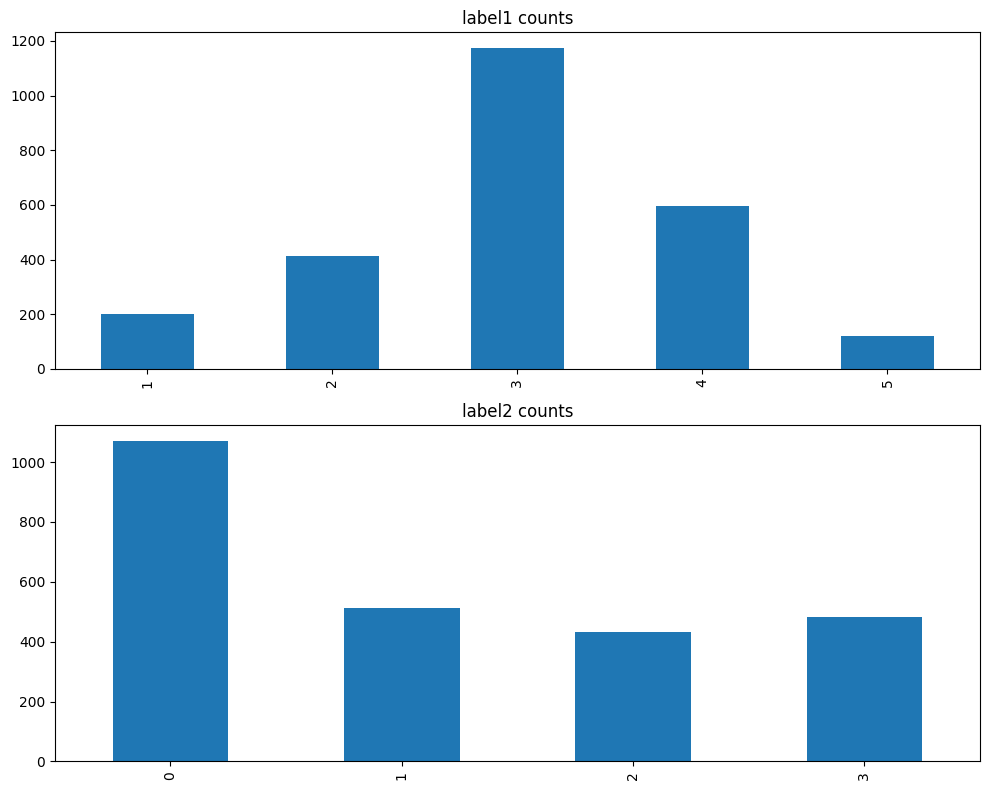

In [12]:
import pandas as pd
import matplotlib.pyplot as plt


# label1, label2 열의 값들이 몇 개씩 있는지 확인 후 오름차순 정렬
label1_counts = df['label1'].value_counts().sort_index()
label2_counts = df['label2'].value_counts().sort_index()

# 결과 출력
print("label1 counts:")
print(label1_counts)
print("\nlabel2 counts:")
print(label2_counts)

# 그래프로 나타내기
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

label1_counts.plot(kind='bar', ax=ax[0], title='label1 counts')
label2_counts.plot(kind='bar', ax=ax[1], title='label2 counts')

plt.tight_layout()
plt.show()

In [13]:
# 모델 정의
class KoBERTForMultiLabelSequenceClassification(torch.nn.Module):
    def __init__(self, num_labels1, num_labels2):
        super(KoBERTForMultiLabelSequenceClassification, self).__init__()
        self.bert = BertModel.from_pretrained('monologg/kobert')
        self.classifier1 = torch.nn.Linear(768, num_labels1)
        self.classifier2 = torch.nn.Linear(768, num_labels2)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output  # CLS 토큰의 히든 상태
        logits1 = self.classifier1(pooled_output)
        logits2 = self.classifier2(pooled_output)
        return logits1, logits2



# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_labels1 = df['label1'].nunique()
num_labels2 = df['label2'].nunique()
model = KoBERTForMultiLabelSequenceClassification(num_labels1, num_labels2).to(device)
optimizer = Adam(model.parameters(), lr=1e-5)
loss_fn1 = CrossEntropyLoss()
loss_fn2 = CrossEntropyLoss()

In [14]:
test_inputs, val_inputs, test_masks, val_masks, test_labels1, val_labels1, test_labels2, val_labels2 = train_test_split(
    test_input_ids, test_attention_masks, test_labels1, test_labels2, random_state=42, test_size=0.5
)

test_dataset = TensorDataset(test_inputs, test_masks, test_labels1, test_labels2)
val_dataset = TensorDataset(val_inputs, val_masks, val_labels1, val_labels2)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [15]:
from tqdm import tqdm
from sklearn.metrics import f1_score

EPOCHS = 10

train_losses = []
val_losses = []
val_accuracies1 = []
val_accuracies2 = []
val_f1_scores1 = []
val_f1_scores2 = []
best_model_path = "best_model.pth"

best_score1 = 0
best_score2 = 0

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    total_correct1 = 0
    total_correct2 = 0
    total_samples = 0

    for batch in tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}/{EPOCHS}"):
        optimizer.zero_grad()
        input_ids, attention_mask, label1, label2 = [b.to(device) for b in batch]
        logits1, logits2 = model(input_ids, attention_mask)

        loss1 = loss_fn1(logits1, label1)
        loss2 = loss_fn2(logits2, label2)
        loss = loss1 + loss2
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct1 += (logits1.argmax(dim=1) == label1).sum().item()
        total_correct2 += (logits2.argmax(dim=1) == label2).sum().item()
        total_samples += label1.size(0)

    avg_train_loss = total_loss / total_samples
    train_losses.append(avg_train_loss)

    # Evaluate on valid set
    model.eval()
    val_loss = 0
    val_correct1 = 0
    val_correct2 = 0
    val_samples = 0
    val_preds1 = []
    val_preds2 = []

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids, attention_mask, label1, label2 = [b.to(device) for b in batch]
            logits1, logits2 = model(input_ids, attention_mask)

            loss1 = loss_fn1(logits1, label1)
            loss2 = loss_fn2(logits2, label2)
            val_loss += (loss1 + loss2).item()

            val_correct1 += (logits1.argmax(dim=1) == label1).sum().item()
            val_correct2 += (logits2.argmax(dim=1) == label2).sum().item()
            val_samples += label1.size(0)

            val_preds1.extend(logits1.argmax(dim=1).tolist())
            val_preds2.extend(logits2.argmax(dim=1).tolist())

    avg_val_loss = val_loss / val_samples
    val_losses.append(avg_val_loss)
    val_accuracy1 = val_correct1 / val_samples
    val_accuracy2 = val_correct2 / val_samples
    val_accuracies1.append(val_accuracy1)
    val_accuracies2.append(val_accuracy2)
    f1_1 = f1_score(val_labels1.cpu(), val_preds1, average='weighted')
    f1_2 = f1_score(val_labels2.cpu(), val_preds2, average='weighted')
    val_f1_scores1.append(f1_1)
    val_f1_scores2.append(f1_2)

    # Print epoch results
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {avg_train_loss:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f}")
    print(f"Validation Accuracy1: {val_accuracy1:.4f}")
    print(f"Validation Accuracy2: {val_accuracy2:.4f}")
    print(f"Validation F1 Score for Label1: {f1_1:.4f}")
    print(f"Validation F1 Score for Label2: {f1_2:.4f}\n")

    # 최고 정확도를 갱신할 경우 모델 저장
    if val_accuracy1 > best_score1 and val_accuracy2 > best_score2:
        best_score1, best_score2 = val_accuracy1, val_accuracy2
        torch.save(model.state_dict(), best_model_path)
        print(f"Model saved for epoch {epoch+1} with accuracy1: {best_score1:.4f} and accuracy2: {best_score2:.4f}\n")


Training Epoch 1/10: 100%|██████████| 500/500 [01:13<00:00,  6.82it/s]



Epoch 1/10
Train Loss: 0.6554
Validation Loss: 0.6627
Validation Accuracy1: 0.4560
Validation Accuracy2: 0.3920
Validation F1 Score for Label1: 0.3768
Validation F1 Score for Label2: 0.2208

Model saved for epoch 1 with accuracy1: 0.4560 and accuracy2: 0.3920



Training Epoch 2/10: 100%|██████████| 500/500 [01:10<00:00,  7.12it/s]



Epoch 2/10
Train Loss: 0.6157
Validation Loss: 0.6200
Validation Accuracy1: 0.4960
Validation Accuracy2: 0.4640
Validation F1 Score for Label1: 0.4142
Validation F1 Score for Label2: 0.3723

Model saved for epoch 2 with accuracy1: 0.4960 and accuracy2: 0.4640



Training Epoch 3/10: 100%|██████████| 500/500 [01:10<00:00,  7.13it/s]



Epoch 3/10
Train Loss: 0.5677
Validation Loss: 0.5916
Validation Accuracy1: 0.5160
Validation Accuracy2: 0.5480
Validation F1 Score for Label1: 0.4643
Validation F1 Score for Label2: 0.5327

Model saved for epoch 3 with accuracy1: 0.5160 and accuracy2: 0.5480



Training Epoch 4/10: 100%|██████████| 500/500 [01:10<00:00,  7.13it/s]



Epoch 4/10
Train Loss: 0.5289
Validation Loss: 0.5756
Validation Accuracy1: 0.5640
Validation Accuracy2: 0.5160
Validation F1 Score for Label1: 0.5241
Validation F1 Score for Label2: 0.5109



Training Epoch 5/10: 100%|██████████| 500/500 [01:09<00:00,  7.16it/s]



Epoch 5/10
Train Loss: 0.4941
Validation Loss: 0.5896
Validation Accuracy1: 0.4920
Validation Accuracy2: 0.5000
Validation F1 Score for Label1: 0.4753
Validation F1 Score for Label2: 0.5095



Training Epoch 6/10: 100%|██████████| 500/500 [01:09<00:00,  7.16it/s]



Epoch 6/10
Train Loss: 0.4482
Validation Loss: 0.5760
Validation Accuracy1: 0.5280
Validation Accuracy2: 0.5680
Validation F1 Score for Label1: 0.5041
Validation F1 Score for Label2: 0.5547

Model saved for epoch 6 with accuracy1: 0.5280 and accuracy2: 0.5680



Training Epoch 7/10: 100%|██████████| 500/500 [01:10<00:00,  7.09it/s]



Epoch 7/10
Train Loss: 0.3945
Validation Loss: 0.5756
Validation Accuracy1: 0.5640
Validation Accuracy2: 0.5800
Validation F1 Score for Label1: 0.5273
Validation F1 Score for Label2: 0.5820

Model saved for epoch 7 with accuracy1: 0.5640 and accuracy2: 0.5800



Training Epoch 8/10: 100%|██████████| 500/500 [01:10<00:00,  7.05it/s]



Epoch 8/10
Train Loss: 0.3346
Validation Loss: 0.6170
Validation Accuracy1: 0.5080
Validation Accuracy2: 0.5680
Validation F1 Score for Label1: 0.5058
Validation F1 Score for Label2: 0.5628



Training Epoch 9/10: 100%|██████████| 500/500 [01:10<00:00,  7.08it/s]



Epoch 9/10
Train Loss: 0.2733
Validation Loss: 0.6561
Validation Accuracy1: 0.5680
Validation Accuracy2: 0.5280
Validation F1 Score for Label1: 0.5588
Validation F1 Score for Label2: 0.5236



Training Epoch 10/10: 100%|██████████| 500/500 [01:10<00:00,  7.14it/s]



Epoch 10/10
Train Loss: 0.2274
Validation Loss: 0.7058
Validation Accuracy1: 0.5400
Validation Accuracy2: 0.5640
Validation F1 Score for Label1: 0.5200
Validation F1 Score for Label2: 0.5521



In [16]:
# 학습이 끝난 후 가장 좋은 성능을 보인 모델을 불러옵니다.
model.load_state_dict(torch.load(best_model_path))
model.eval()

# 테스트 데이터셋에 대한 예측을 수행
true_labels1 = []
true_labels2 = []
predicted_labels1 = []
predicted_labels2 = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, label1, label2 = [b.to(device) for b in batch]
        logits1, logits2 = model(input_ids, attention_mask)

        true_labels1.extend(label1.tolist())
        true_labels2.extend(label2.tolist())
        predicted_labels1.extend(logits1.argmax(dim=1).tolist())
        predicted_labels2.extend(logits2.argmax(dim=1).tolist())

# f1-score를 포함한 성능 지표를 출력
accuracy1 = sum([1 if true == pred else 0 for true, pred in zip(true_labels1, predicted_labels1)]) / len(true_labels1)
accuracy2 = sum([1 if true == pred else 0 for true, pred in zip(true_labels2, predicted_labels2)]) / len(true_labels2)

f1_1 = f1_score(true_labels1, predicted_labels1, average='weighted')
f1_2 = f1_score(true_labels2, predicted_labels2, average='weighted')

print(f"Test Accuracy for Label1: {accuracy1:.4f}")
print(f"Test Accuracy for Label2: {accuracy2:.4f}")
print(f"F1 Score for Label1: {f1_1:.4f}")
print(f"F1 Score for Label2: {f1_2:.4f}")

Test Accuracy for Label1: 0.5960
Test Accuracy for Label2: 0.5360
F1 Score for Label1: 0.5684
F1 Score for Label2: 0.5308


In [17]:
print("\nTrue vs Predicted Labels:")
for true1, pred1, true2, pred2 in zip(true_labels1, predicted_labels1, true_labels2, predicted_labels2):
    print(f"Label1 - True: {true1 + 1}, Predicted: {pred1 + 1} | Label2 - True: {true2 + 1}, Predicted: {pred2 + 1}")



True vs Predicted Labels:
Label1 - True: 3, Predicted: 3 | Label2 - True: 4, Predicted: 4
Label1 - True: 5, Predicted: 2 | Label2 - True: 3, Predicted: 2
Label1 - True: 3, Predicted: 3 | Label2 - True: 1, Predicted: 1
Label1 - True: 4, Predicted: 3 | Label2 - True: 4, Predicted: 3
Label1 - True: 2, Predicted: 2 | Label2 - True: 1, Predicted: 1
Label1 - True: 2, Predicted: 4 | Label2 - True: 3, Predicted: 1
Label1 - True: 2, Predicted: 2 | Label2 - True: 1, Predicted: 1
Label1 - True: 3, Predicted: 3 | Label2 - True: 1, Predicted: 1
Label1 - True: 4, Predicted: 4 | Label2 - True: 4, Predicted: 2
Label1 - True: 2, Predicted: 2 | Label2 - True: 1, Predicted: 1
Label1 - True: 1, Predicted: 4 | Label2 - True: 1, Predicted: 1
Label1 - True: 3, Predicted: 3 | Label2 - True: 1, Predicted: 3
Label1 - True: 4, Predicted: 4 | Label2 - True: 4, Predicted: 4
Label1 - True: 3, Predicted: 3 | Label2 - True: 3, Predicted: 3
Label1 - True: 5, Predicted: 2 | Label2 - True: 1, Predicted: 1
Label1 - True